In [295]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import pandas as pd
import os
import pandas as pd
import json
import glob
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense
from sklearn.preprocessing import MinMaxScaler

### Load data

In [296]:
df = pd.read_csv('../../regioes/dadosFinais.csv', sep=';')
# print(df.columns)
print(df['codLocation'].unique())

local = 1711116  #1711116
df = df[df['codLocation'] == local]
df.head()

[1711105 1711107 1711110 1711111 1711115 1711116]


,Avaliacoes Total,Avaliacoes Apartamentos,Avaliacoes Moradias,Capital Divida Total,Capital Divida 3M,Capital Divida 6M,Capital Divida 12M,Juros Totais,Capital Amortizado,Unemployed population,...,Date,moving_avg_price_sell,exp_moving_avg_price_sell,price_to_rent_ratio,propriedades_unicas_rent,propriedades_unicas_sell,moving_avg_price_rent,exp_moving_avg_price_rent,moving_avg_Reducao_sell,moving_avg_Reducao_rent
1648,444,393,51.0,51817,97727,95476,94260.0,44,196,371.2,...,20180401,228502.000000,223989.808580,171.633929,-1.0,-1.0,1240.666667,1238.122829,17.666667,7.000000
1649,444,393,51.0,51817,97727,95476,94260.0,44,196,371.2,...,20180408,221680.000000,220666.904290,175.987045,2.0,-12.0,1236.333333,1236.561414,10.666667,1.333333
1650,444,393,51.0,51817,97727,95476,94260.0,44,196,371.2,...,20180415,213070.666667,215540.952145,154.603233,0.0,2.0,1276.000000,1298.780707,3.666667,0.833333
1651,444,393,51.0,51817,97727,95476,94260.0,44,196,371.2,...,20180422,213027.666667,213432.476072,165.874411,0.0,-1.0,1290.000000,1286.390354,5.666667,1.500000
1652,444,393,51.0,51817,97727,95476,94260.0,44,196,371.2,...,20180429,210368.000000,211398.738036,159.091945,1.0,-5.0,1317.000000,1301.195177,4.666667,1.166667


In [297]:
# Separar variáveis independentes (X) e dependente (y)
X = df.drop(columns=['Preço médio_sell'])

# y = df[['Date','Preço médio_sell']]
y = df['Preço médio_sell'] # drop the m2

train_size = 0.7
test_size = 0.2
valid_size = 0.1

total_size = len(df)
train_end = int(train_size * total_size)
test_end = int((train_size + test_size) * total_size)

X_train = X.iloc[:train_end]
X_test = X.iloc[train_end:test_end]
X_valid = X.iloc[test_end:]

y_train = y.iloc[:train_end]
y_test = y.iloc[train_end:test_end]
y_valid = y.iloc[test_end:]


print(f"Tamanho do conjunto de treinamento: {len(X_train)}")
print(f"Tamanho do conjunto de teste: {len(X_test)}")
print(f"Tamanho do conjunto de validação: {len(X_valid)}")

# Preparar dados para treino
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
X_valid_scaled = scaler_X.transform(X_valid)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))
y_valid_scaled = scaler_y.transform(y_valid.values.reshape(-1, 1))


Tamanho do conjunto de treinamento: 231
Tamanho do conjunto de teste: 66
Tamanho do conjunto de validação: 34


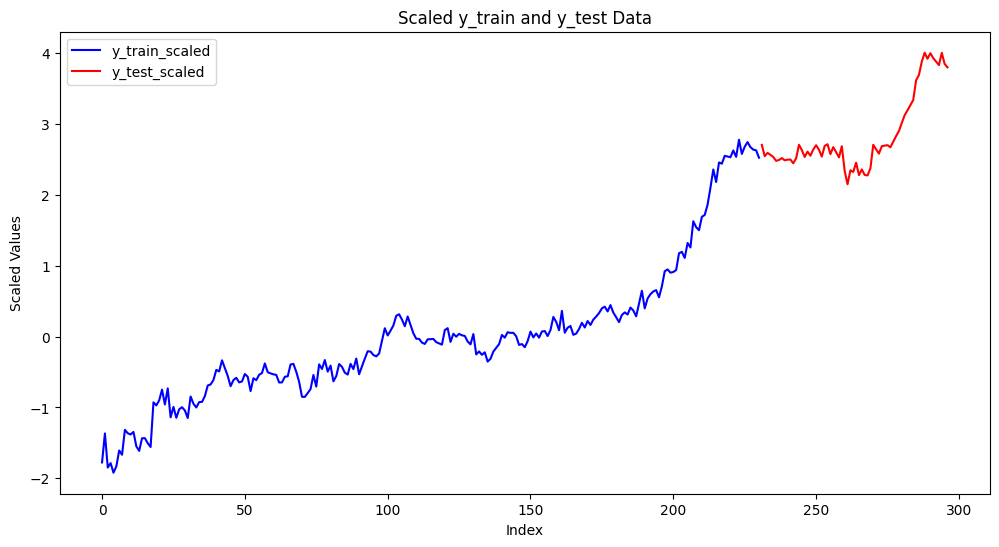

In [298]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_train_scaled, label='y_train_scaled', color='blue')
plt.plot(range(len(y_train_scaled), len(y_train_scaled) + len(y_test_scaled)), y_test_scaled, label='y_test_scaled', color='red')

plt.title('Scaled y_train and y_test Data')
plt.xlabel('Index')
plt.ylabel('Scaled Values')
plt.legend()
plt.show()

### Treino Dense neural network (MLP)

In [299]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.losses import Huber
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

batch_size = 32
initial_learning_rate = 0.0009  # A learning rate inicial comum
steps_per_epoch = len(X_train_scaled) // batch_size  # Tamanho do batch (32) e tamanho do dataset
epochs = 650  # Total de épocas para treinamento
decay_steps = steps_per_epoch * 10  # Reduzir a learning rate após 10 épocas
decay_rate = 0.964  # Diminuir a learning rate em 5% a cada 10 épocas
activationF = 'tanh'  # Função de ativação comum

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True  # Usar degraus para ajustar a learning rate
)


# model = Sequential()
# model.add(Dense(320, activation=activationF, input_shape=(X_train.shape[1],),
#                 kernel_regularizer=regularizers.l2(0.0014)))
# # model.add(BatchNormalization()) 
# # model.add(Dropout(0.3))

# model.add(Dense(64, activation=activationF, kernel_regularizer=regularizers.l2(0.003)))
# # model.add(Dense(64, activation='tanh'))
# # model.add(BatchNormalization()) 
# # model.add(Dropout(0.1))
# model.add(Dense(32, activation=activationF)) #, kernel_regularizer=regularizers.l2(0.003)))
# model.add(Dense(1))

model = Sequential()
model.add(Dense(320, activation=activationF, input_shape=(X_train.shape[1],),
                kernel_regularizer=regularizers.l2(0.003)))
model.add(BatchNormalization()) 
model.add(Dropout(0.25))

model.add(Dense(64, activation=activationF, kernel_regularizer=regularizers.l2(0.003)))
# model.add(Dense(64, activation='tanh'))
model.add(BatchNormalization()) 
model.add(Dense(batch_size, activation=activationF)) #, kernel_regularizer=regularizers.l2(0.003)))
model.add(Dense(1))

# # 3. Compilar o modelo
# initial_learning_rate = 0.001
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=100000,  # quantas etapas para o decaimento
#     decay_rate=0.96,     # taxa de decaimento
#     staircase=True       # se true, a learning rate diminui em "degraus"
# )

def r2_scoree(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    r2 = 1 - SS_res / (SS_tot + K.epsilon())
    return r2


# Compilar o modelo com a learning rate adaptativa
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
              loss=tf.keras.losses.Huber(), metrics=['mae', r2_scoree])

early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=150, 
                               restore_best_weights=True)

# 4. Treinar o modelo

history = model.fit(X_train_scaled, y_train_scaled, 
                    validation_data=(X_test_scaled, y_test_scaled), 
                    epochs=epochs, batch_size=batch_size,

                    callbacks=[early_stopping]
                    )


Epoch 1/650


c:\Users\ruben\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.9964 - mae: 0.6363 - r2_scoree: 0.2950 - val_loss: 2.3905 - val_mae: 2.1992 - val_r2_scoree: -6128.0796
Epoch 2/650
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7912 - mae: 0.3657 - r2_scoree: 0.7545 - val_loss: 2.1615 - val_mae: 1.9645 - val_r2_scoree: -5608.7007
Epoch 3/650
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7564 - mae: 0.3188 - r2_scoree: 0.8206 - val_loss: 2.1399 - val_mae: 1.9609 - val_r2_scoree: -5573.6880
Epoch 4/650
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7293 - mae: 0.2717 - r2_scoree: 0.7550 - val_loss: 2.2099 - val_mae: 2.0432 - val_r2_scoree: -5787.9722
Epoch 5/650
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7187 - mae: 0.2749 - r2_scoree: 0.8396 - val_loss: 1.9160 - val_mae: 1.7338 - val_r2_scoree: -5081.8296
Epoch 6/650
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6968 - mae: 0.2514 - r2_scoree: 0.8702 - val_loss: 1.7364 - val_mae: 1.5481 - val_r2_scoree: -4583.2085
Epoch 7/650
8/8 ━━━━━━━━━━━━━━━━━

### Metricas

In [253]:
def calcular_metricas(y_real, y_pred, conjunto):
    mae = mean_absolute_error(y_real, y_pred)
    r2 = r2_score(y_real, y_pred)
    mse = mean_squared_error(y_real, y_pred)
    acuracia = (1 - (mae / np.mean(y_real))) * 100
    print(f"{conjunto}: MAE: {mae:.2f}, R²: {r2:.2f}, MSE: {mse:.2f}, Acurácia: {acuracia:.2f}%")
    return mae, r2, mse, acuracia

In [300]:
y_pred_scaled_test = model.predict(X_test_scaled)
y_pred_scaled_train = model.predict(X_train_scaled)

y_pred_test = scaler_y.inverse_transform(y_pred_scaled_test)
y_test_real = scaler_y.inverse_transform(y_test_scaled)
y_pred_train = scaler_y.inverse_transform(y_pred_scaled_train)
y_train_real = scaler_y.inverse_transform(y_train_scaled)

mae_train, r2_train, mse_train, acuracia_train = calcular_metricas(y_train_real, 
                                                                   y_pred_train, 
                                                                   "Treino")

mae_test, r2_test, mse_test, acuracia_test = calcular_metricas(y_test_real, 
                                                               y_pred_test, 
                                                               "Teste")


# Treino: MAE: 698.41, R²: 1.00, MSE: 757757.99, Acurácia: 99.60%
# Teste: MAE: 2335.73, R²: 0.67, MSE: 9264346.26, Acurácia: 98.92%

# Treino: MAE: 1015.19, R²: 1.00, MSE: 1717047.37, Acurácia: 99.42%
# Teste: MAE: 2365.07, R²: 0.66, MSE: 9709691.80, Acurácia: 98.90%

# Treino: MAE: 917.56, R²: 0.99, MSE: 1369166.21, Acurácia: 99.61%
# Teste: MAE: 5063.53, R²: -0.07, MSE: 62384214.54, Acurácia: 98.18%

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Treino: MAE: 758.46, R²: 1.00, MSE: 969851.85, Acurácia: 99.68%
Teste: MAE: 5072.26, R²: 0.06, MSE: 54771786.16, Acurácia: 98.17%


dict_keys(['loss', 'mae', 'r2_scoree', 'val_loss', 'val_mae', 'val_r2_scoree'])


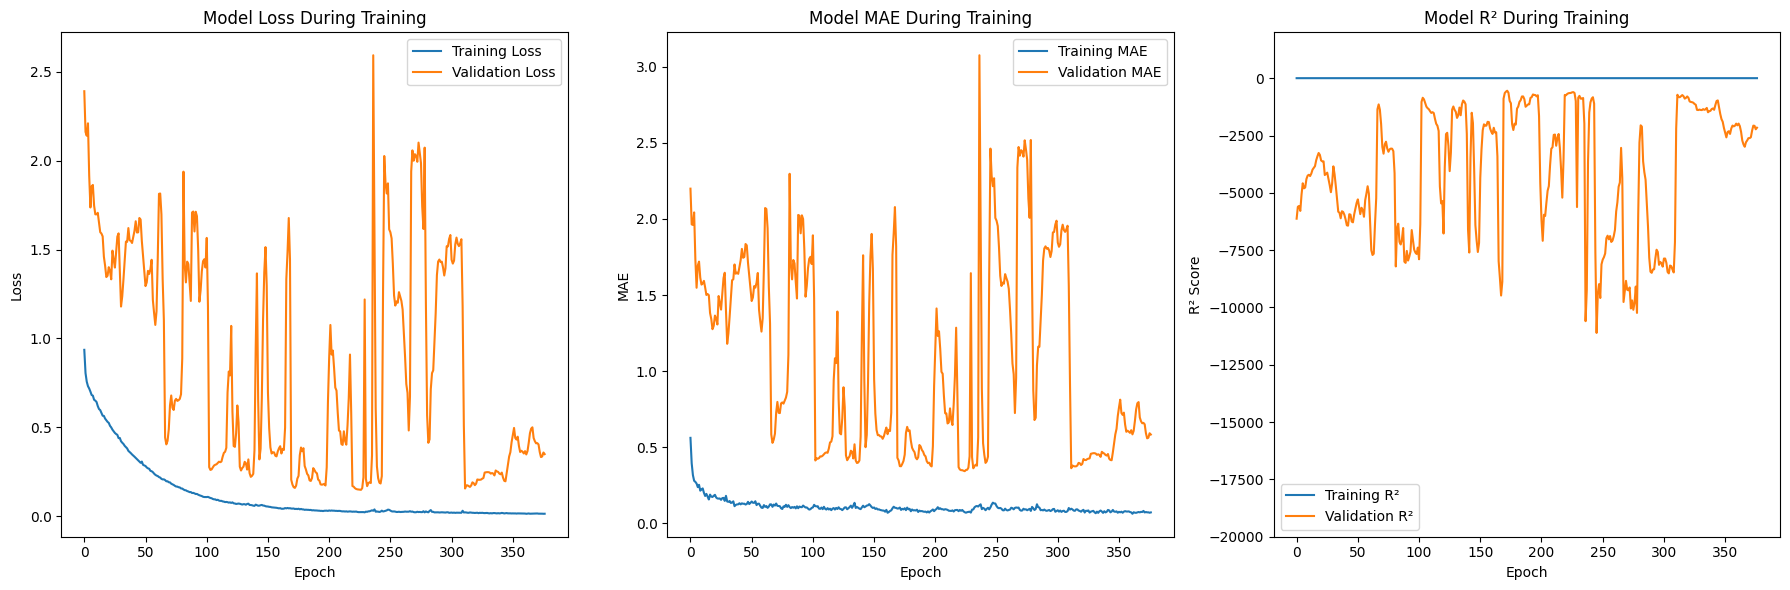

In [301]:
history_dict = history.history
print(history_dict.keys())

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Loss
axs[0].plot(history_dict['loss'], label='Training Loss')
axs[0].plot(history_dict['val_loss'], label='Validation Loss')
axs[0].set_title('Model Loss During Training')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].legend()

# MAE
axs[1].plot(history_dict['mae'], label='Training MAE')
axs[1].plot(history_dict['val_mae'], label='Validation MAE')
axs[1].set_title('Model MAE During Training')
axs[1].set_ylabel('MAE')
axs[1].set_xlabel('Epoch')
axs[1].legend()

# R² Score
axs[2].plot(history_dict['r2_scoree'], label='Training R²')
axs[2].plot(history_dict['val_r2_scoree'], label='Validation R²')
axs[2].set_title('Model R² During Training')
axs[2].set_ylabel('R² Score')
axs[2].set_xlabel('Epoch')
axs[2].set_ylim(-20000, 2000) 
axs[2].legend()

plt.tight_layout()
plt.show()

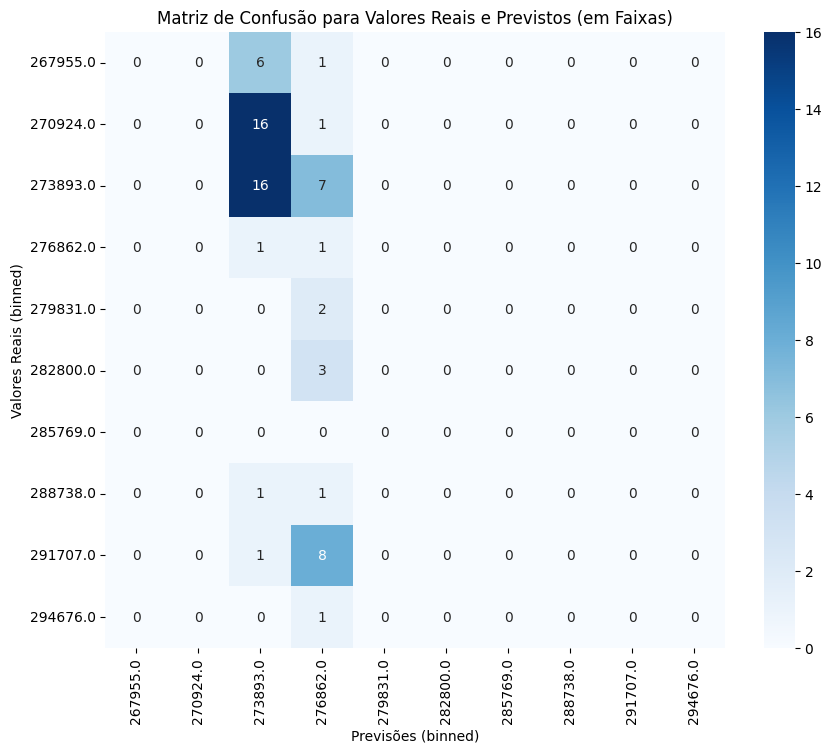

In [302]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

n_bins = 10

min_val = min(min(y_test), min(y_pred_test))
max_val = max(max(y_test), max(y_pred_test))

bins = np.linspace(min_val, max_val, n_bins)

y_test_binned = np.digitize(y_test, bins)
y_pred_binned = np.digitize(y_pred_test, bins)

conf_matrix = confusion_matrix(y_test_binned, y_pred_binned, labels=range(1, n_bins+1))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=bins.round(2), yticklabels=bins.round(2))
plt.title('Matriz de Confusão para Valores Reais e Previstos (em Faixas)')
plt.xlabel('Previsões (binned)')
plt.ylabel('Valores Reais (binned)')
plt.show()

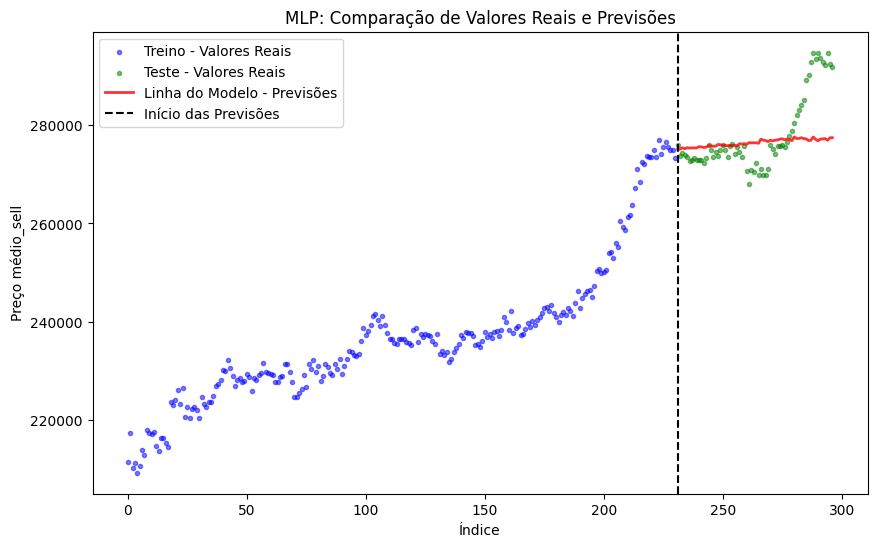

In [303]:
train_indices = range(len(y_train))
test_indices = range(len(y_train), len(y_train) + len(y_test))

plt.figure(figsize=(10, 6))
plt.scatter(train_indices, y_train, color='blue', label='Treino - Valores Reais', 
            alpha=0.5, marker='.')

plt.scatter(test_indices, y_test, color='green', label='Teste - Valores Reais', 
            alpha=0.5, marker='.')

plt.plot(test_indices, y_pred_test[:len(y_test)], color='red', 
         label='Linha do Modelo - Previsões', alpha=0.8, linewidth=2)

plt.axvline(x=len(y_train), color='black', linestyle='--', label='Início das Previsões')

plt.title('MLP: Comparação de Valores Reais e Previsões')
plt.xlabel('Índice')
plt.ylabel('Preço médio_sell')
plt.legend()

# Exibir o gráfico
# plt.grid(True)
plt.show()

In [304]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_train_scaled_df

,Avaliacoes Total,Avaliacoes Apartamentos,Avaliacoes Moradias,Capital Divida Total,Capital Divida 3M,Capital Divida 6M,Capital Divida 12M,Juros Totais,Capital Amortizado,Unemployed population,...,Date,moving_avg_price_sell,exp_moving_avg_price_sell,price_to_rent_ratio,propriedades_unicas_rent,propriedades_unicas_sell,moving_avg_price_rent,exp_moving_avg_price_rent,moving_avg_Reducao_sell,moving_avg_Reducao_rent
0,-0.205414,-0.041167,-0.959667,-1.180380,-1.180599,-1.404461,-1.456456,0.135627,-0.281205,1.058709,...,-1.509704,-0.592232,-0.914654,-1.732105,-0.343233,-0.312665,1.463394,1.451313,1.025983,3.601630
1,-0.205414,-0.041167,-0.959667,-1.180380,-1.180599,-1.404461,-1.456456,0.135627,-0.281205,1.058709,...,-1.509171,-1.075912,-1.150944,-1.612450,0.251418,-1.132140,1.433080,1.440344,-0.403791,-0.214261
2,-0.205414,-0.041167,-0.959667,-1.180380,-1.180599,-1.404461,-1.456456,0.135627,-0.281205,1.058709,...,-1.508638,-1.686313,-1.515448,-2.200230,-0.145016,-0.089172,1.710568,1.877452,-1.833564,-0.550958
3,-0.205414,-0.041167,-0.959667,-1.180380,-1.180599,-1.404461,-1.456456,0.135627,-0.281205,1.058709,...,-1.508105,-1.689362,-1.665381,-1.890418,-0.145016,-0.312665,1.808506,1.790406,-1.425058,-0.102029
4,-0.205414,-0.041167,-0.959667,-1.180380,-1.180599,-1.404461,-1.456456,0.135627,-0.281205,1.058709,...,-1.507572,-1.877932,-1.809999,-2.076849,0.053201,-0.610656,1.997384,1.894414,-1.629311,-0.326493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,0.030112,-0.238166,1.354167,2.242721,1.907956,1.980412,1.946246,0.795205,1.874274,-1.384726,...,1.560924,2.733306,2.772577,0.823477,1.044286,0.134322,0.021153,0.035821,2.660009,-0.887654
227,-0.582255,-0.685891,0.108256,2.380235,1.950648,2.016076,2.022116,2.444149,1.776298,-0.993917,...,1.566711,2.765896,2.760286,0.796700,0.449635,0.581308,0.070122,0.065196,3.340854,-0.663190
228,-0.582255,-0.685891,0.108256,2.380235,1.950648,2.016076,2.022116,2.444149,1.776298,-0.993917,...,1.567244,2.751905,2.736292,0.536146,1.242503,-0.461660,0.180884,0.209851,2.660009,-0.887654
229,-0.582255,-0.685891,0.108256,2.380235,1.950648,2.016076,2.022116,2.444149,1.776298,-0.993917,...,1.567777,2.712414,2.718926,0.331745,-0.541450,-0.163669,0.341781,0.394583,0.685560,-0.887654


#### Dados de validacao

In [305]:
y_valid_pred_scaled = model.predict(X_valid_scaled)
y_valid_pred = scaler_y.inverse_transform(y_valid_pred_scaled)
y_valid_real = scaler_y.inverse_transform(y_valid_scaled)

mae_valid, r2_valid, mse_valid, acc_valid = calcular_metricas(y_valid_real, 
                                                              y_valid_pred, 
                                                              "Validação")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Validação: MAE: 27062.75, R²: -13.47, MSE: 790378013.85, Acurácia: 91.10%


### Results

In [306]:
results = { 
    'Conjunto': ['Treino', 'Teste', 'Validação'],
    'MAE': [mae_train, mae_test, mae_valid],
    'R²': [r2_train, r2_test, r2_valid],
    'MSE': [mse_train, mse_test, mse_valid],
    'Acurácia (%)': [acuracia_train, acuracia_test, acc_valid]
}

results_df = pd.DataFrame(results)
results_df

,Conjunto,MAE,R²,MSE,Acurácia (%)
0,Treino,758.461918,0.995322,9.698518e+05,99.679995
1,Teste,5072.260890,0.062403,5.477179e+07,98.174969
2,Validação,27062.749081,-13.471404,7.903780e+08,91.096304


In [251]:
import os
import json

def salvar_resultados_modelo(modelo_nome, localizacao,resultados_df):
    # Criar estrutura para salvar
    results_dict = resultados_df.to_dict(orient='records')
    results_dict_with_model = {
        "Modelo": modelo_nome,
        "Localização": localizacao,
        "Resultados": results_dict
    }

    # Caminho do diretório e do arquivo JSON
    directory = "modelos"
    json_filename = os.path.join(directory, 'resultadosModelos.json')

    # Criar o diretório se não existir
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Verificar se o arquivo já existe
    if os.path.exists(json_filename):
        with open(json_filename, 'r') as json_file:
            existing_data = json.load(json_file)
    else:
        existing_data = []

    # Adicionar os novos resultados
    existing_data.append(results_dict_with_model)

    # Salvar de volta no arquivo JSON
    with open(json_filename, 'w') as json_file:
        json.dump(existing_data, json_file, indent=4)

    print(f"Dados salvos e adicionados ao arquivo {json_filename}")


salvar_resultados_modelo("MLP", local, results_df)

Dados salvos e adicionados ao arquivo modelos\resultadosModelos.json
